Facility Expense Classification - AI/ML/NLP Assessment

CELL 1:  Package Installation & Imports
CELL 2:  Data Loading & Initial Inspection
CELL 3:  Data Cleaning & Feature Engineering
CELL 4:  Weak Supervision - Silver Label Generation
CELL 5:  EDA 
CELL 6:  Train/Test Split & Data Preparation
CELL 7:  Approach 1 - TF-IDF + Logistic Regression (Baseline)
CELL 8:  Approach 2 - SetFit Implementation (Primary Model)
CELL 9:  Model Comparison & Evaluation
CELL 10: Executive Summary & Production Recommendations


In [1]:
# ============================================================================
# STEP 1: Install Required Packages
# ============================================================================

import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

print("📦 Installing required packages...\n")

packages = [
    'pandas',
    'numpy',
    'scikit-learn',
    'matplotlib',
    'seaborn',
    'wordcloud',
    'transformers',
    'setfit',
    'openpyxl'
]

for pkg in packages:
    print(f"   Installing {pkg}...")
    install(pkg)

print("\n✅ All packages installed successfully!\n")

# ============================================================================
# STEP 2: Import Libraries
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from collections import Counter
from wordcloud import WordCloud

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_recall_fscore_support
)

# Deep Learning / Transformers
from transformers import pipeline
from setfit import SetFitModel, Trainer, TrainingArguments
from datasets import Dataset

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("="*90)
print("  FACILITY EXPENSE CLASSIFICATION - END-TO-END ML PIPELINE")
print("="*90)
print("\n✅ Environment ready. Let's build something great!\n")


📦 Installing required packages...

   Installing pandas...
   Installing numpy...
   Installing scikit-learn...
   Installing matplotlib...
   Installing seaborn...
   Installing wordcloud...
   Installing transformers...
   Installing setfit...
   Installing openpyxl...

✅ All packages installed successfully!

  FACILITY EXPENSE CLASSIFICATION - END-TO-END ML PIPELINE

✅ Environment ready. Let's build something great!



In [2]:
"""
CELL 2: Data Loading & Initial Quality Assessment
Goal: Load raw data and understand its structure before any transformations
"""

print("="*90)
print("CELL 2: DATA LOADING & INITIAL INSPECTION")
print("="*90)

# ============================================================================
# Load Data
# ============================================================================

df = pd.read_excel('data.xlsx')

print(f"\n📊 Dataset Loaded Successfully")
print(f"   Rows: {df.shape[0]:,}")
print(f"   Columns: {df.shape[1]}")
print(f"   Memory: {df.memory_usage(deep=True).sum() / 1024:.1f} KB\n")

# ============================================================================
# Initial Data Inspection
# ============================================================================

print("📋 Column Overview:")
print(df.dtypes)

print("\n🔍 First 5 Records:")
display(df.head())

print("\n📈 Statistical Summary:")
display(df.describe())

print("\n⚠️  Missing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

print("\n💡 Initial Observations:")
print(f"   • Credit column: {df['Credit'].nunique()} unique values (all zeros → can drop)")
print(f"   • Net column: Equals Debit in all cases → redundant")
print(f"   • Remarks: Primary text feature for classification")
print(f"   • No explicit target labels → Need weak supervision")

print("\n" + "="*90)


CELL 2: DATA LOADING & INITIAL INSPECTION

📊 Dataset Loaded Successfully
   Rows: 268
   Columns: 5
   Memory: 50.2 KB

📋 Column Overview:
Year        object
Debit      float64
Credit       int64
Net        float64
Remarks     object
dtype: object

🔍 First 5 Records:


,Year,Debit,Credit,Net,Remarks
0,FY23,30000.0,0,30000.0,"Services Professional Services , Consultancy Architects Services Design at Ameni"
1,FY23,270000.0,0,270000.0,"Services Professional Services , Consultancy Architects Services Design at Ameni"
2,FY23,250000.0,0,250000.0,Exp reclass entry in N2 (Godrej)
3,FY23,14500.0,0,14500.0,Dispenser Water - Frosty plus - (Make - Atlantis)
4,FY23,59400.0,0,59400.0,"Almirah - Office use , Steel Almirah with four shelves making five Compartment,"



📈 Statistical Summary:


,Debit,Credit,Net
count,2.680000e+02,268.0,2.680000e+02
mean,3.527194e+05,0.0,3.527194e+05
std,1.582780e+06,0.0,1.582780e+06
min,3.000000e+02,0.0,3.000000e+02
25%,8.191875e+03,0.0,8.191875e+03
50%,3.010000e+04,0.0,3.010000e+04
75%,1.014150e+05,0.0,1.014150e+05
max,1.273548e+07,0.0,1.273548e+07



⚠️  Missing Values:
         Missing Count  Percentage
Remarks              1        0.37

💡 Initial Observations:
   • Credit column: 1 unique values (all zeros → can drop)
   • Net column: Equals Debit in all cases → redundant
   • Remarks: Primary text feature for classification
   • No explicit target labels → Need weak supervision



In [3]:
"""
CELL 3: Data Cleaning & Feature Engineering
Goal: Transform raw data into ML-ready features
"""

print("="*90)
print("CELL 3: DATA CLEANING & FEATURE ENGINEERING")
print("="*90)

# ============================================================================
# STEP 1: Remove Redundant Columns
# ============================================================================

print("\n🧹 STEP 1: Removing Redundant Columns\n")

initial_cols = df.shape[1]
df = df.drop(columns=['Credit', 'Net'])

print(f"   Dropped: Credit (all zeros), Net (duplicate of Debit)")
print(f"   Columns: {initial_cols} → {df.shape[1]}")

# ============================================================================
# STEP 2: Filter Invalid Records
# ============================================================================

print("\n🔍 STEP 2: Filtering Invalid Records\n")

initial_rows = len(df)

# Remove zero/null debits
df = df[df['Debit'].notna() & (df['Debit'] > 0)]

# Remove empty remarks
df = df[df['Remarks'].notna() & (df['Remarks'].str.strip() != '')]

print(f"   Removed {initial_rows - len(df)} invalid records")
print(f"   Final dataset: {len(df)} valid expense records")

# ============================================================================
# STEP 3: Text Cleaning Function
# ============================================================================

print("\n🔤 STEP 3: Cleaning Remarks Text Field\n")

def clean_text(text):
    """
    Clean and normalize expense description text
    
    Transformations:
    - Lowercase (AC, ac, Ac → same token)
    - Remove special chars (keep alphanumeric + spaces/hyphens)
    - Collapse multiple spaces
    - Remove scientific notation artifacts
    """
    if pd.isna(text):
        return None
    
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)  # Collapse spaces
    text = re.sub(r'[^a-z0-9\s\-]', ' ', text)  # Keep alphanumeric + hyphen
    text = re.sub(r'\d{10,}', ' ', text)  # Remove long numbers (sci notation)
    text = text.strip()
    
    return text if text else None

df['Remarks'] = df['Remarks'].apply(clean_text)

# Remove any that became empty after cleaning
initial_len = len(df)
df = df[df['Remarks'].notna() & (df['Remarks'] != '')]
print(f"   Cleaned {initial_len} text descriptions")
print(f"   Removed {initial_len - len(df)} empty after cleaning")

# ============================================================================
# STEP 4: Feature Engineering
# ============================================================================

print("\n⚙️  STEP 4: Engineering Analytical Features\n")

# Log-transformed amount (reduces right-skew)
df['log_debit'] = np.log1p(df['Debit'])

# Text length features
df['remark_word_count'] = df['Remarks'].apply(lambda x: len(x.split()))
df['remark_char_count'] = df['Remarks'].apply(lambda x: len(x))

# Year encoding
df['year_encoded'] = df['Year'].astype('category').cat.codes

print(f"   Created features:")
print(f"   • log_debit: Log-transformed amount (stabilizes variance)")
print(f"   • remark_word_count: Token count (range: {df['remark_word_count'].min()}-{df['remark_word_count'].max()})")
print(f"   • remark_char_count: Character length")
print(f"   • year_encoded: Categorical encoding")

# ============================================================================
# Final Data Summary
# ============================================================================

print("\n" + "="*90)
print("✅ DATA CLEANING COMPLETE - FINAL DATASET SUMMARY")
print("="*90)

print(f"\n📊 Cleaned Dataset:")
print(f"   Records: {len(df):,}")
print(f"   Features: {list(df.columns)}")

print(f"\n💰 Financial Summary:")
print(f"   Total Spend: ₹{df['Debit'].sum():,.2f}")
print(f"   Average Transaction: ₹{df['Debit'].mean():,.2f}")
print(f"   Median Transaction: ₹{df['Debit'].median():,.2f}")
print(f"   Range: ₹{df['Debit'].min():,.2f} - ₹{df['Debit'].max():,.2f}")

print(f"\n📝 Text Statistics:")
print(f"   Avg words per remark: {df['remark_word_count'].mean():.1f}")
print(f"   Avg characters: {df['remark_char_count'].mean():.0f}")

print("\n" + "="*90)


CELL 3: DATA CLEANING & FEATURE ENGINEERING

🧹 STEP 1: Removing Redundant Columns

   Dropped: Credit (all zeros), Net (duplicate of Debit)
   Columns: 5 → 3

🔍 STEP 2: Filtering Invalid Records

   Removed 1 invalid records
   Final dataset: 267 valid expense records

🔤 STEP 3: Cleaning Remarks Text Field

   Cleaned 267 text descriptions
   Removed 0 empty after cleaning

⚙️  STEP 4: Engineering Analytical Features

   Created features:
   • log_debit: Log-transformed amount (stabilizes variance)
   • remark_word_count: Token count (range: 1-50)
   • remark_char_count: Character length
   • year_encoded: Categorical encoding

✅ DATA CLEANING COMPLETE - FINAL DATASET SUMMARY

📊 Cleaned Dataset:
   Records: 267
   Features: ['Year', 'Debit', 'Remarks', 'log_debit', 'remark_word_count', 'remark_char_count', 'year_encoded']

💰 Financial Summary:
   Total Spend: ₹94,526,558.45
   Average Transaction: ₹354,032.05
   Median Transaction: ₹30,200.00
   Range: ₹300.00 - ₹12,735,479.00

📝 Text 

In [4]:
"""
CELL 4: Weak Supervision - Generating Training Labels
Goal: Create "silver standard" labels using ensemble of labeling functions
Strategy: Combine domain rules + cost heuristics + zero-shot NLP + action verbs
"""

print("="*90)
print("CELL 4: WEAK SUPERVISION - SILVER LABEL GENERATION")
print("="*90)

print("""
CHALLENGE: No ground-truth labels in dataset

SOLUTION: Weak Supervision Framework
- Combine multiple noisy signals (4 Labeling Functions)
- Use majority voting to create consensus labels
- Flag low-confidence cases for awareness

This is a production-realistic scenario where perfect labels are rare.
""")

import re
from collections import Counter

# ============================================================================
# LABELING FUNCTION 1: Domain Keyword Rules
# ============================================================================

def lf_keywords(remark):
    """
    Classify based on facility management domain expertise
    
    Logic:
    - Services: Labor, contracts, professional work
    - Equipment: Durable assets, machinery
    - Material: Consumables, building components
    """
    if pd.isna(remark):
        return None
    
    remark_lower = remark.lower()
    
    # Service indicators
    service_keywords = [
        'consultancy', 'consultant', 'testing', 'commissioning',
        'amc', 'service', 'installation charges', 'professional',
        'work', 'providing', 'fixing', 'laying',
        'civil work', 'mep work', 'interior', 'carpentry'
    ]
    
    # Equipment indicators  
    equipment_keywords = [
        'ac ', 'air conditioner', 'almirah', 'dispenser',
        'machine', 'camera', 'cctv', 'server', 'computer',
        'furniture', 'desk', 'chair', 'unit', 'device',
        'odu', 'split ac', 'inverter', 'stand', 'portable'
    ]
    
    # Material indicators
    material_keywords = [
        'pipe', 'piping', 'cable', 'wiring', 'wire',
        'steel', 'copper', 'pvc', 'insulation',
        'cement', 'drain', 'tube'
    ]
    
    # Check in priority order
    if any(kw in remark_lower for kw in service_keywords):
        return 'Services'
    if any(kw in remark_lower for kw in equipment_keywords):
        return 'Equipment'
    if any(kw in remark_lower for kw in material_keywords):
        return 'Material'
    
    return None  # Abstain if unclear

# ============================================================================
# LABELING FUNCTION 2: Cost-Based Heuristics (STRATEGY 1 - IMPROVED)
# ============================================================================

def lf_cost(debit):
    """
    Use transaction amount as weak signal
    
    IMPROVED Heuristic (reduces abstentions):
    - High amounts (>100K): Typically large service contracts
    - Mid-high (10K-100K): Likely equipment purchases
    - Low amounts (<10K): Usually material purchases
    """
    if debit > 100000:
        return 'Services'
    elif debit >= 10000 and debit <= 100000:
        return 'Equipment'  # NEW: Vote on mid-range transactions
    elif debit < 10000:
        return 'Material'
    else:
        return None  # Only abstain on edge cases

# ============================================================================
# LABELING FUNCTION 3: Zero-Shot Classification
# ============================================================================

print("\n🤖 Initializing Zero-Shot Classifier (BART-MNLI)...")
print("   This provides semantic understanding without domain-specific training")

from transformers import pipeline

zero_shot_classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=-1  # CPU mode
)

def lf_zero_shot(remark):
    """
    Use pretrained NLP model for semantic classification
    
    Advantage: Captures context and language patterns
    beyond simple keyword matching
    """
    if pd.isna(remark) or len(remark) < 5:
        return None
    
    try:
        result = zero_shot_classifier(
            remark,
            candidate_labels=['Services', 'Equipment', 'Material'],
            multi_label=False
        )
        return result['labels'][0]
    except:
        return None

# ============================================================================
# LABELING FUNCTION 4: Action Verb Detection (STRATEGY 2 - NEW)
# ============================================================================

def lf_action_verbs(remark):
    """
    Detect service-indicating action verbs vs product acquisition keywords
    
    Logic:
    - Services: Action verbs (installation, testing, commissioning, repair)
    - Equipment/Material: Product keywords (supply, purchase, make/model specs)
    
    This LF captures linguistic patterns that keywords alone miss.
    """
    if pd.isna(remark):
        return None
    
    remark_lower = remark.lower()
    
    # Strong service action verbs
    service_actions = [
        r'\b(install|installation|installing)\b',
        r'\b(test|testing)\b',
        r'\b(commission|commissioning)\b',
        r'\b(lay|laying)\b',
        r'\b(fix|fixing|fixed)\b',
        r'\b(repair|repairing)\b',
        r'\b(maintain|maintenance)\b',
        r'\b(consultancy|consulting|consultant)\b',
        r'\b(work|works|working)\b.*\b(interior|civil|mep|carpentry)\b'
    ]
    
    # Product acquisition keywords (Equipment/Material indicators)
    product_keywords = [
        r'\b(supply|supplying|supplied)\b',
        r'\b(purchase|purchasing|purchased)\b',
        r'\b(procurement|procured)\b',
        r'\bmake\s*[-:]\s*\w+\b',  # "make - atlantis" or "make: samsung"
        r'\b\d+\.?\d*\s*tr\s*(split|inverter|ac|unit)\b'  # "1.5 tr split ac"
    ]
    
    # Count matches
    service_matches = sum(1 for pattern in service_actions if re.search(pattern, remark_lower))
    product_matches = sum(1 for pattern in product_keywords if re.search(pattern, remark_lower))
    
    # Decision logic
    if service_matches > product_matches and service_matches >= 1:
        return 'Services'
    elif product_matches > 0:
        # Distinguish Equipment from Material by material-specific keywords
        if any(kw in remark_lower for kw in ['pipe', 'piping', 'cable', 'wiring', 'wire', 'steel', 'copper', 'pvc', 'insulation']):
            return 'Material'
        else:
            return 'Equipment'
    
    return None  # Abstain if no clear pattern

print("\n📋 Weak Supervision Ensemble Configured:")
print("   LF1: Domain keyword rules")
print("   LF2: Cost-based thresholds (improved: 3 ranges)")
print("   LF3: Zero-shot semantic classification")
print("   LF4: Action verb pattern detection")
print("   Total: 4 labeling functions → Majority voting\n")

# ============================================================================
# MAJORITY VOTING RESOLVER (UPDATED FOR 4 LFs)
# ============================================================================

def resolve_label(row):
    """
    Aggregate votes from 4 labeling functions
    
    Voters:
    1. Keyword-based LF
    2. Cost-based LF (improved thresholds)
    3. Zero-shot NLP
    4. Action verb LF (NEW)
    
    Rules:
    - If 2+ functions agree → High confidence label
    - If only 1 vote or tie → Low confidence (use most common)
    
    Returns: (label, is_low_confidence)
    """
    remark = row['Remarks']
    debit = row['Debit']
    
    # Collect votes from ALL 4 labeling functions
    vote_keyword = lf_keywords(remark)
    vote_cost = lf_cost(debit)
    vote_zeroshot = lf_zero_shot(remark)
    vote_action = lf_action_verbs(remark)  # NEW 4th voter
    
    # Filter out None votes
    votes = [v for v in [vote_keyword, vote_cost, vote_zeroshot, vote_action] if v is not None]
    
    if not votes:
        return ('Equipment', True)  # Default to majority class with low confidence
    
    # Count vote distribution
    vote_counts = Counter(votes)
    most_common = vote_counts.most_common(1)[0]
    
    # Check for majority (2+ votes out of 4 possible voters)
    if most_common[1] >= 2:
        return (most_common[0], False)  # High confidence
    
    # Single vote or no clear majority
    return (most_common[0], True)  # Low confidence

# ============================================================================
# APPLY WEAK SUPERVISION TO DATASET
# ============================================================================

print("🏗️  Generating silver labels for all records...")
print("   This may take 2-3 minutes (zero-shot inference on CPU)...\n")

results = df.apply(resolve_label, axis=1)
df['Predicted_Category'] = results.apply(lambda x: x[0])
df['Low_Confidence'] = results.apply(lambda x: x[1])

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("="*90)
print("✅ SILVER LABEL GENERATION COMPLETE")
print("="*90)

category_dist = df['Predicted_Category'].value_counts()
print(f"\n📊 Label Distribution:")
for cat, count in category_dist.items():
    pct = count / len(df) * 100
    print(f"   {cat:12s}: {count:3d} records ({pct:5.1f}%)")

confidence_dist = df['Low_Confidence'].value_counts()
high_conf = confidence_dist.get(False, 0)
low_conf = confidence_dist.get(True, 0)

print(f"\n🎯 Confidence Assessment:")
print(f"   High Confidence (2+ votes agree): {high_conf:3d} ({high_conf/len(df)*100:.1f}%)")
print(f"   Low Confidence (single vote/tie):  {low_conf:3d} ({low_conf/len(df)*100:.1f}%)")

print(f"\n📋 Sample Labeled Records:")
sample_cols = ['Debit', 'Remarks', 'Predicted_Category', 'Low_Confidence']
display(df[sample_cols].head(10))

print("\n" + "="*90)
print("💡 KEY INSIGHT:")
print("="*90)
print(f"""
These 'silver labels' are noisy but adequate for training:
- {high_conf/len(df)*100:.0f}% have high agreement (strong signal)
- {low_conf/len(df)*100:.0f}% are uncertain (expected with weak supervision)

IMPROVEMENTS FROM 4-LF ENSEMBLE:
✓ Cost-based LF now votes on mid-range transactions (10K-100K)
✓ Action verb LF captures linguistic patterns (verbs vs nouns)
✓ Higher agreement rate → More high-confidence labels

SetFit's contrastive learning is robust to this level of label noise.
In production, high-confidence predictions would auto-classify,
while low-confidence cases get human review.
""")
print("="*90)


CELL 4: WEAK SUPERVISION - SILVER LABEL GENERATION

CHALLENGE: No ground-truth labels in dataset

SOLUTION: Weak Supervision Framework
- Combine multiple noisy signals (4 Labeling Functions)
- Use majority voting to create consensus labels
- Flag low-confidence cases for awareness

This is a production-realistic scenario where perfect labels are rare.


🤖 Initializing Zero-Shot Classifier (BART-MNLI)...
   This provides semantic understanding without domain-specific training


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu



📋 Weak Supervision Ensemble Configured:
   LF1: Domain keyword rules
   LF2: Cost-based thresholds (improved: 3 ranges)
   LF3: Zero-shot semantic classification
   LF4: Action verb pattern detection
   Total: 4 labeling functions → Majority voting

🏗️  Generating silver labels for all records...
   This may take 2-3 minutes (zero-shot inference on CPU)...

✅ SILVER LABEL GENERATION COMPLETE

📊 Label Distribution:
   Equipment   : 126 records ( 47.2%)
   Services    :  89 records ( 33.3%)
   Material    :  52 records ( 19.5%)

🎯 Confidence Assessment:
   High Confidence (2+ votes agree): 193 (72.3%)
   Low Confidence (single vote/tie):   74 (27.7%)

📋 Sample Labeled Records:


,Debit,Remarks,Predicted_Category,Low_Confidence
0,30000.0,services professional services consultancy architects services design at ameni,Services,False
1,270000.0,services professional services consultancy architects services design at ameni,Services,False
2,250000.0,exp reclass entry in n2 godrej,Services,True
3,14500.0,dispenser water - frosty plus - make - atlantis,Equipment,False
4,59400.0,almirah - office use steel almirah with four shelves making five compartment,Equipment,False
5,59400.0,almirah - office use steel almirah with four shelves making five compartment,Equipment,False
6,12400.0,dispenser water - frosty plus - make - atlantis,Equipment,False
7,12735479.0,space matrix cost t f from project upgradation of toilets as g f 1st floor interior mep wor...,Services,False
8,315000.0,provision reclass of godrej may22,Services,True
9,30200.0,1 5 tr split ac - 2 star - non inverter daikin,Equipment,False



💡 KEY INSIGHT:

These 'silver labels' are noisy but adequate for training:
- 72% have high agreement (strong signal)
- 28% are uncertain (expected with weak supervision)

IMPROVEMENTS FROM 4-LF ENSEMBLE:
✓ Cost-based LF now votes on mid-range transactions (10K-100K)
✓ Action verb LF captures linguistic patterns (verbs vs nouns)
✓ Higher agreement rate → More high-confidence labels

SetFit's contrastive learning is robust to this level of label noise.
In production, high-confidence predictions would auto-classify,
while low-confidence cases get human review.



In [5]:
# ============================================================================
# BONUS: Manual Spot-Check of Label Quality
# ============================================================================

print("\n" + "="*90)
print("🔍 SPOT-CHECK: Sample High vs Low Confidence Labels")
print("="*90)

print("\n✅ HIGH-CONFIDENCE SAMPLES (Should look obviously correct):\n")
high_conf_samples = df[df['Low_Confidence'] == False].sample(5, random_state=42)
for idx, row in high_conf_samples.iterrows():
    print(f"   {row['Predicted_Category']:12s} | ₹{row['Debit']:>10,.0f} | {row['Remarks'][:70]}")

print("\n⚠️  LOW-CONFIDENCE SAMPLES (Should look ambiguous):\n")
low_conf_samples = df[df['Low_Confidence'] == True].sample(5, random_state=42)
for idx, row in low_conf_samples.iterrows():
    print(f"   {row['Predicted_Category']:12s} | ₹{row['Debit']:>10,.0f} | {row['Remarks'][:70]}")

print("\n💡 INTERPRETATION:")
print("   If high-confidence labels look correct → Weak supervision working well!")
print("   If low-confidence labels look ambiguous → System correctly flagged uncertainty")



🔍 SPOT-CHECK: Sample High vs Low Confidence Labels

✅ HIGH-CONFIDENCE SAMPLES (Should look obviously correct):

   Services     | ₹    90,720 | wc 03 07 2022 supplying  fixing  testing and commissioning of chilled 
   Equipment    | ₹     3,550 | chair - pp shell with wooden legs for food court dor- 16-12-22
   Equipment    | ₹    18,500 | sitc of av system for training room
   Equipment    | ₹    41,500 | wc 18 01 23 sitc of network rack  t-5 ground floor - 42u rack enclosur
   Equipment    | ₹     4,150 | pinnacle po 28151 shoe shine machine t7 qty01

⚠️  LOW-CONFIDENCE SAMPLES (Should look ambiguous):

   Services     | ₹   201,381 | project solutions24997confined space r
   Equipment    | ₹    10,000 | sitc of dashboard maintenance charges  per year  includes cloud charge
   Services     | ₹   177,000 | mep -hoto of tower 11a mlcp
   Services     | ₹   250,000 | exp reclass entry in n2  godrej
   Material     | ₹     2,302 | sitc of av system for training room

💡 INTERPRETATION:
 

In [6]:
"""
CELL 5: Strategic EDA - Business Intelligence Dashboard
Goal: Analyze actual training labels with executive-ready visualizations
Tools: Plotly for interactive, publication-quality charts
"""

print("="*90)
print("CELL 5: STRATEGIC EDA - BUSINESS INSIGHTS FROM SILVER LABELS")
print("="*90)

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# ============================================================================
# INSIGHT 1: The Volume-Value Paradox
# ============================================================================

print("\n" + "="*90)
print("💡 INSIGHT 1: THE VOLUME-VALUE DISCONNECT")
print("="*90)

# Calculate category-level statistics
category_stats = df.groupby('Predicted_Category').agg({
    'Debit': ['count', 'sum', 'mean', 'median']
}).round(0)

category_stats.columns = ['Transaction_Count', 'Total_Spend', 'Avg_Amount', 'Median_Amount']
category_stats = category_stats.reset_index()

# Calculate percentages
total_transactions = category_stats['Transaction_Count'].sum()
total_spend = category_stats['Total_Spend'].sum()

category_stats['Pct_Transactions'] = (category_stats['Transaction_Count'] / total_transactions * 100).round(1)
category_stats['Pct_Spend'] = (category_stats['Total_Spend'] / total_spend * 100).round(1)
category_stats['Value_Volume_Ratio'] = (category_stats['Pct_Spend'] / category_stats['Pct_Transactions']).round(2)

print("\n📊 Category Statistics:\n")
display(category_stats[['Predicted_Category', 'Transaction_Count', 'Pct_Transactions', 
                        'Total_Spend', 'Pct_Spend', 'Value_Volume_Ratio']])

# Identify strategic insights
max_volume_cat = category_stats.loc[category_stats['Transaction_Count'].idxmax(), 'Predicted_Category']
max_value_cat = category_stats.loc[category_stats['Total_Spend'].idxmax(), 'Predicted_Category']

print(f"\n🎯 STRATEGIC INSIGHT:")
print(f"   Volume Leader: {max_volume_cat} ({category_stats[category_stats['Predicted_Category']==max_volume_cat]['Pct_Transactions'].values[0]}% of transactions)")
print(f"   Value Leader:  {max_value_cat} ({category_stats[category_stats['Predicted_Category']==max_value_cat]['Pct_Spend'].values[0]:.1f}% of spend)")

if max_volume_cat != max_value_cat:
    print(f"\n   ⚠️  PARADOX DETECTED: High-volume category ≠ High-value category")
    print(f"      Classification accuracy for '{max_value_cat}' has greater financial impact!")

# ============================================================================
# VISUALIZATION 1: Interactive Volume-Value Dashboard
# ============================================================================

print("\n📊 Generating Interactive Volume-Value Dashboard...\n")

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('<b>Transaction Count by Category</b>', '<b>Total Spend by Category</b>'),
    specs=[[{'type': 'bar'}, {'type': 'bar'}]],
    horizontal_spacing=0.12
)

# Color palette
colors = {'Material': '#FF6B6B', 'Services': '#4ECDC4', 'Equipment': '#45B7D1'}
color_list = [colors.get(cat, '#95A5A6') for cat in category_stats['Predicted_Category']]

# Left: Transaction volume
fig.add_trace(
    go.Bar(
        x=category_stats['Predicted_Category'],
        y=category_stats['Transaction_Count'],
        text=category_stats['Transaction_Count'].astype(str),
        textposition='outside',
        textfont=dict(size=14, color='black', family='Arial Black'),
        marker=dict(color=color_list, line=dict(color='black', width=1.5)),
        name='Volume',
        showlegend=False,
        hovertemplate='<b>%{x}</b><br>Count: %{y}<br>Percentage: %{customdata}%<extra></extra>',
        customdata=category_stats['Pct_Transactions']
    ),
    row=1, col=1
)

# Right: Total spend
fig.add_trace(
    go.Bar(
        x=category_stats['Predicted_Category'],
        y=category_stats['Total_Spend'],
        text=['₹' + f"{val/1e6:.1f}M" for val in category_stats['Total_Spend']],
        textposition='outside',
        textfont=dict(size=14, color='black', family='Arial Black'),
        marker=dict(color=color_list, line=dict(color='black', width=1.5)),
        name='Value',
        showlegend=False,
        hovertemplate='<b>%{x}</b><br>Spend: ₹%{y:,.0f}<br>Percentage: %{customdata}%<extra></extra>',
        customdata=category_stats['Pct_Spend']
    ),
    row=1, col=2
)

# Update axes
fig.update_xaxes(title_text="<b>Category</b>", row=1, col=1, tickfont=dict(size=12))
fig.update_xaxes(title_text="<b>Category</b>", row=1, col=2, tickfont=dict(size=12))
fig.update_yaxes(title_text="<b>Number of Transactions</b>", row=1, col=1, tickfont=dict(size=11))
fig.update_yaxes(title_text="<b>Total Spend (₹)</b>", row=1, col=2, tickfont=dict(size=11))

# Update layout
fig.update_layout(
    title_text="<b>Facility Expense Analysis: The Volume-Value Disconnect</b>",
    title_font=dict(size=18, color='#2C3E50', family='Arial Black'),
    title_x=0.5,
    height=450,
    plot_bgcolor='rgba(240,240,240,0.5)',
    paper_bgcolor='white',
    font=dict(family='Arial', size=12)
)

fig.show()

# ============================================================================
# INSIGHT 2: Transaction Amount Distribution
# ============================================================================

print("\n" + "="*90)
print("💰 INSIGHT 2: TRANSACTION AMOUNT PATTERNS")
print("="*90)

# Percentile analysis
percentiles = df['Debit'].quantile([0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).round(0)
print("\nAmount Distribution (Percentiles):")
for pct, val in percentiles.items():
    print(f"   {int(pct*100)}th percentile: ₹{val:,.0f}")

print(f"\n📊 INTERPRETATION:")
print(f"   • 50% of transactions ≤ ₹{percentiles[0.50]:,.0f} (median)")
print(f"   • Top 10% transactions > ₹{percentiles[0.90]:,.0f}")
print(f"   • Top 1% outliers > ₹{percentiles[0.99]:,.0f} (manual review threshold)")

# ============================================================================
# VISUALIZATION 2: Interactive Box Plot (Amount Distribution by Category)
# ============================================================================

print("\n📊 Generating Interactive Amount Distribution Chart...\n")

fig = go.Figure()

for cat in category_stats['Predicted_Category']:
    cat_data = df[df['Predicted_Category'] == cat]['Debit'].dropna()
    
    fig.add_trace(go.Box(
        y=cat_data,
        name=cat,
        marker=dict(color=colors.get(cat, '#95A5A6')),
        boxmean='sd',  # Show mean and std deviation
        hovertemplate='<b>%{fullData.name}</b><br>Amount: ₹%{y:,.0f}<extra></extra>'
    ))

fig.update_layout(
    title='<b>Transaction Amount Distribution by Category</b><br><sub>Box plots show median, IQR, and outliers</sub>',
    title_font=dict(size=16, color='#2C3E50', family='Arial Black'),
    title_x=0.5,
    yaxis=dict(
        title='<b>Transaction Amount (₹)</b>',
        type='log',  # Log scale for better visualization
        tickformat=',.0f',
        gridcolor='rgba(128,128,128,0.2)'
    ),
    xaxis=dict(title='<b>Category</b>', tickfont=dict(size=12)),
    height=500,
    plot_bgcolor='rgba(240,240,240,0.3)',
    paper_bgcolor='white',
    font=dict(family='Arial', size=12),
    showlegend=False
)

fig.show()

# ============================================================================
# INSIGHT 3: Class Balance Analysis (Critical for Model Training)
# ============================================================================

print("\n" + "="*90)
print("⚖️  INSIGHT 3: CLASS BALANCE ANALYSIS")
print("="*90)

# Calculate imbalance ratio
max_class_count = category_stats['Transaction_Count'].max()
min_class_count = category_stats['Transaction_Count'].min()
imbalance_ratio = max_class_count / min_class_count

print(f"\nClass Balance Metrics:")
print(f"   Largest class:  {category_stats.loc[category_stats['Transaction_Count'].idxmax(), 'Predicted_Category']} ({max_class_count} samples)")
print(f"   Smallest class: {category_stats.loc[category_stats['Transaction_Count'].idxmin(), 'Predicted_Category']} ({min_class_count} samples)")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print(f"\n   ⚠️  SEVERE IMBALANCE DETECTED (>{imbalance_ratio:.0f}:1)")
    print(f"      → Use class_weight='balanced' in models")
    print(f"      → Evaluate with F1-score (not accuracy)")
else:
    print(f"\n   ✅ Moderate imbalance (<3:1) - standard techniques applicable")

# ============================================================================
# VISUALIZATION 3: Sunburst Chart (Hierarchical Spend Breakdown)
# ============================================================================

print("\n📊 Generating Hierarchical Spend Breakdown...\n")

# Prepare data for sunburst
sunburst_data = []
for _, row in category_stats.iterrows():
    sunburst_data.append({
        'Category': row['Predicted_Category'],
        'Spend': row['Total_Spend'],
        'Count': row['Transaction_Count']
    })

# Create sunburst chart
fig = go.Figure(go.Sunburst(
    labels=['Total Spend'] + category_stats['Predicted_Category'].tolist(),
    parents=[''] + ['Total Spend'] * len(category_stats),
    values=[total_spend] + category_stats['Total_Spend'].tolist(),
    text=['₹' + f"{total_spend/1e6:.1f}M<br>Total"] + 
         ['₹' + f"{val/1e6:.1f}M<br>{pct:.1f}%" for val, pct in 
          zip(category_stats['Total_Spend'], category_stats['Pct_Spend'])],
    textinfo='label+text',
    marker=dict(
        colors=['#ECF0F1'] + [colors.get(cat, '#95A5A6') for cat in category_stats['Predicted_Category']],
        line=dict(color='white', width=2)
    ),
    hovertemplate='<b>%{label}</b><br>Amount: ₹%{value:,.0f}<extra></extra>'
))

fig.update_layout(
    title='<b>Spend Distribution Hierarchy</b>',
    title_font=dict(size=16, color='#2C3E50', family='Arial Black'),
    title_x=0.5,
    height=500,
    font=dict(family='Arial', size=13)
)

fig.show()

# ============================================================================
# VISUALIZATION 4: Confidence Distribution (Model Training Quality)
# ============================================================================

print("\n📊 Generating Label Confidence Analysis...\n")

confidence_dist = df['Low_Confidence'].value_counts()
high_conf = confidence_dist.get(False, 0)
low_conf = confidence_dist.get(True, 0)

fig = go.Figure(data=[
    go.Bar(
        x=['High Confidence<br>(2+ votes)', 'Low Confidence<br>(single vote)'],
        y=[high_conf, low_conf],
        text=[f"{high_conf}<br>({high_conf/len(df)*100:.1f}%)", 
              f"{low_conf}<br>({low_conf/len(df)*100:.1f}%)"],
        textposition='outside',
        textfont=dict(size=14, color='black', family='Arial Black'),
        marker=dict(
            color=['#27AE60', '#E74C3C'],
            line=dict(color='black', width=1.5)
        ),
        hovertemplate='<b>%{x}</b><br>Count: %{y}<extra></extra>'
    )
])

fig.update_layout(
    title='<b>Silver Label Confidence Distribution</b><br><sub>Quality of weak supervision output</sub>',
    title_font=dict(size=16, color='#2C3E50', family='Arial Black'),
    title_x=0.5,
    yaxis=dict(title='<b>Number of Records</b>', gridcolor='rgba(128,128,128,0.2)'),
    xaxis=dict(title='<b>Confidence Level</b>'),
    height=450,
    plot_bgcolor='rgba(240,240,240,0.3)',
    paper_bgcolor='white',
    font=dict(family='Arial', size=12)
)

fig.show()

print(f"\n💡 LABEL QUALITY INSIGHT:")
print(f"   • {high_conf/len(df)*100:.0f}% high-confidence labels (strong training signal)")
print(f"   • {low_conf/len(df)*100:.0f}% low-confidence labels (acceptable noise level)")
print(f"   • SetFit's contrastive learning tolerates 20-30% label noise")

# ============================================================================
# VISUALIZATION 5: Text Complexity Heatmap
# ============================================================================

print("\n📊 Generating Text Complexity Analysis...\n")

# Calculate text statistics by category
text_analysis = df.groupby('Predicted_Category').agg({
    'remark_word_count': ['mean', 'median', 'max'],
    'remark_char_count': ['mean', 'median', 'max']
}).round(1)

text_analysis.columns = ['Avg_Words', 'Median_Words', 'Max_Words', 
                         'Avg_Chars', 'Median_Chars', 'Max_Chars']
text_analysis = text_analysis.reset_index()

print("\n📝 TEXT COMPLEXITY BY CATEGORY:\n")
display(text_analysis)

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    x=['Avg Words', 'Median Words', 'Max Words', 'Avg Chars', 'Median Chars', 'Max Chars'],
    y=text_analysis['Predicted_Category'],
    z=text_analysis[['Avg_Words', 'Median_Words', 'Max_Words', 
                     'Avg_Chars', 'Median_Chars', 'Max_Chars']].values,
    text=text_analysis[['Avg_Words', 'Median_Words', 'Max_Words', 
                        'Avg_Chars', 'Median_Chars', 'Max_Chars']].values,
    texttemplate='%{text:.0f}',
    textfont=dict(size=12, color='white', family='Arial Black'),
    colorscale='Viridis',
    hovertemplate='<b>%{y}</b><br>%{x}: %{z:.0f}<extra></extra>'
))

fig.update_layout(
    title='<b>Text Complexity Heatmap by Category</b>',
    title_font=dict(size=16, color='#2C3E50', family='Arial Black'),
    title_x=0.5,
    xaxis=dict(title='<b>Metric</b>', side='bottom'),
    yaxis=dict(title='<b>Category</b>'),
    height=400,
    font=dict(family='Arial', size=12)
)

fig.show()

longest_cat = text_analysis.loc[text_analysis['Avg_Words'].idxmax(), 'Predicted_Category']
print(f"\n📊 INTERPRETATION:")
print(f"   • '{longest_cat}' has longest descriptions (avg {text_analysis[text_analysis['Predicted_Category']==longest_cat]['Avg_Words'].values[0]:.0f} words)")
print(f"   • Longer text → More context for SetFit to learn from")
print(f"   • Shorter text → May require keyword-heavy features (TF-IDF advantage)")

# ============================================================================
# FINAL EDA SUMMARY
# ============================================================================

print("\n" + "="*90)
print("✅ EDA COMPLETE - KEY TAKEAWAYS FOR MODELING")
print("="*90)

print(f"""
1. VOLUME-VALUE DISCONNECT:
   • {max_volume_cat}: {category_stats[category_stats['Predicted_Category']==max_volume_cat]['Pct_Transactions'].values[0]:.0f}% of transactions, {category_stats[category_stats['Predicted_Category']==max_volume_cat]['Pct_Spend'].values[0]:.0f}% of spend
   • {max_value_cat}: {category_stats[category_stats['Predicted_Category']==max_value_cat]['Pct_Transactions'].values[0]:.0f}% of transactions, {category_stats[category_stats['Predicted_Category']==max_value_cat]['Pct_Spend'].values[0]:.0f}% of spend
   → Classification errors on '{max_value_cat}' have highest financial impact

2. CLASS IMBALANCE:
   • Imbalance ratio: {imbalance_ratio:.1f}:1
   → Use weighted F1-score (not accuracy) for evaluation
   → Apply class_weight='balanced' in baseline model

3. LABEL QUALITY:
   • {high_conf/len(df)*100:.0f}% high-confidence silver labels
   → Sufficient signal-to-noise ratio for SetFit training

4. TEXT PATTERNS:
   • Clear keyword distinctions across categories
   • Variable description length ({text_analysis['Avg_Words'].min():.0f}-{text_analysis['Avg_Words'].max():.0f} words avg)
   → Both TF-IDF (keywords) and SetFit (semantics) should perform well

NEXT STEP: Train/Test split with stratification (Cell 6)
""")
print("="*90)


CELL 5: STRATEGIC EDA - BUSINESS INSIGHTS FROM SILVER LABELS

💡 INSIGHT 1: THE VOLUME-VALUE DISCONNECT

📊 Category Statistics:



,Predicted_Category,Transaction_Count,Pct_Transactions,Total_Spend,Pct_Spend,Value_Volume_Ratio
0,Equipment,126,47.2,5131958.0,5.4,0.11
1,Material,52,19.5,703469.0,0.7,0.04
2,Services,89,33.3,88691131.0,93.8,2.82



🎯 STRATEGIC INSIGHT:
   Volume Leader: Equipment (47.2% of transactions)
   Value Leader:  Services (93.8% of spend)

   ⚠️  PARADOX DETECTED: High-volume category ≠ High-value category
      Classification accuracy for 'Services' has greater financial impact!

📊 Generating Interactive Volume-Value Dashboard...




💰 INSIGHT 2: TRANSACTION AMOUNT PATTERNS

Amount Distribution (Percentiles):
   25th percentile: ₹8,350
   50th percentile: ₹30,200
   75th percentile: ₹102,610
   90th percentile: ₹274,800
   95th percentile: ₹842,144
   99th percentile: ₹10,644,940

📊 INTERPRETATION:
   • 50% of transactions ≤ ₹30,200 (median)
   • Top 10% transactions > ₹274,800
   • Top 1% outliers > ₹10,644,940 (manual review threshold)

📊 Generating Interactive Amount Distribution Chart...




⚖️  INSIGHT 3: CLASS BALANCE ANALYSIS

Class Balance Metrics:
   Largest class:  Equipment (126 samples)
   Smallest class: Material (52 samples)
   Imbalance ratio: 2.42:1

   ✅ Moderate imbalance (<3:1) - standard techniques applicable

📊 Generating Hierarchical Spend Breakdown...




📊 Generating Label Confidence Analysis...




💡 LABEL QUALITY INSIGHT:
   • 72% high-confidence labels (strong training signal)
   • 28% low-confidence labels (acceptable noise level)
   • SetFit's contrastive learning tolerates 20-30% label noise

📊 Generating Text Complexity Analysis...


📝 TEXT COMPLEXITY BY CATEGORY:



,Predicted_Category,Avg_Words,Median_Words,Max_Words,Avg_Chars,Median_Chars,Max_Chars
0,Equipment,11.1,9.5,36,63.1,55.0,172
1,Material,8.8,7.0,15,49.3,41.5,94
2,Services,10.2,10.0,50,65.9,78.0,246



📊 INTERPRETATION:
   • 'Equipment' has longest descriptions (avg 11 words)
   • Longer text → More context for SetFit to learn from
   • Shorter text → May require keyword-heavy features (TF-IDF advantage)

✅ EDA COMPLETE - KEY TAKEAWAYS FOR MODELING

1. VOLUME-VALUE DISCONNECT:
   • Equipment: 47% of transactions, 5% of spend
   • Services: 33% of transactions, 94% of spend
   → Classification errors on 'Services' have highest financial impact

2. CLASS IMBALANCE:
   • Imbalance ratio: 2.4:1
   → Use weighted F1-score (not accuracy) for evaluation
   → Apply class_weight='balanced' in baseline model

3. LABEL QUALITY:
   • 72% high-confidence silver labels
   → Sufficient signal-to-noise ratio for SetFit training

4. TEXT PATTERNS:
   • Clear keyword distinctions across categories
   • Variable description length (9-11 words avg)
   → Both TF-IDF (keywords) and SetFit (semantics) should perform well

NEXT STEP: Train/Test split with stratification (Cell 6)



In [7]:
"""
CELL 6: Train/Test Split & Data Preparation
Goal: Prepare stratified train/validation sets for modeling
"""

print("="*90)
print("CELL 6: TRAIN/VALIDATION SPLIT")
print("="*90)

# ============================================================================
# Create Label Mapping
# ============================================================================

label_mapping = {
    'Services': 0,
    'Equipment': 1,
    'Material': 2
}

reverse_mapping = {v: k for k, v in label_mapping.items()}

# Encode labels
df['label'] = df['Predicted_Category'].map(label_mapping)

print(f"\n📋 Label Encoding:")
for cat, code in label_mapping.items():
    print(f"   {cat:12s} → {code}")

# ============================================================================
# Stratified Split (80/20)
# ============================================================================

X = df['Remarks'].values
y = df['label'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\n📊 Dataset Split:")
print(f"   Training:   {len(X_train):3d} samples ({len(X_train)/len(df)*100:.0f}%)")
print(f"   Validation: {len(X_val):3d} samples ({len(X_val)/len(df)*100:.0f}%)")

# Verify stratification
print(f"\n🎯 Class Distribution Verification:")
print(f"\n   Training Set:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for label_code, count in train_dist.items():
    print(f"   {reverse_mapping[label_code]:12s}: {count:3d} ({count/len(y_train)*100:.1f}%)")

print(f"\n   Validation Set:")
val_dist = pd.Series(y_val).value_counts().sort_index()
for label_code, count in val_dist.items():
    print(f"   {reverse_mapping[label_code]:12s}: {count:3d} ({count/len(y_val)*100:.1f}%)")

print("\n✅ Stratification successful - distributions match\n")
print("="*90)


CELL 6: TRAIN/VALIDATION SPLIT

📋 Label Encoding:
   Services     → 0
   Equipment    → 1
   Material     → 2

📊 Dataset Split:
   Training:   213 samples (80%)
   Validation:  54 samples (20%)

🎯 Class Distribution Verification:

   Training Set:
   Services    :  71 (33.3%)
   Equipment   : 101 (47.4%)
   Material    :  41 (19.2%)

   Validation Set:
   Services    :  18 (33.3%)
   Equipment   :  25 (46.3%)
   Material    :  11 (20.4%)

✅ Stratification successful - distributions match



CELL 7: APPROACH 1 - TF-IDF + LOGISTIC REGRESSION (BASELINE)

📝 STEP 1: TF-IDF Feature Extraction

   Vocabulary size: 627 terms
   Training matrix: (213, 627)
   Validation matrix: (54, 627)
   Sparsity: 98.0%

🎯 STEP 2: Training Logistic Regression Classifier

   ✅ Training complete in 0.016 seconds
   Model converged: 20 iterations

🔍 STEP 3: Model Interpretability - Top Predictive Keywords

   SERVICES:
      1. and                  (weight: +1.173)
      2. commissioning        (weight: +1.085)
      3. testing              (weight: +1.030)
      4. commissioning of     (weight: +0.857)
      5. services             (weight: +0.725)

   EQUIPMENT:
      1. supply of            (weight: +0.602)
      2. power                (weight: +0.570)
      3. make                 (weight: +0.537)
      4. unit                 (weight: +0.530)
      5. water                (weight: +0.529)

   MATERIAL:
      1. sitc                 (weight: +1.660)
      2. link                 (weight: +0.9

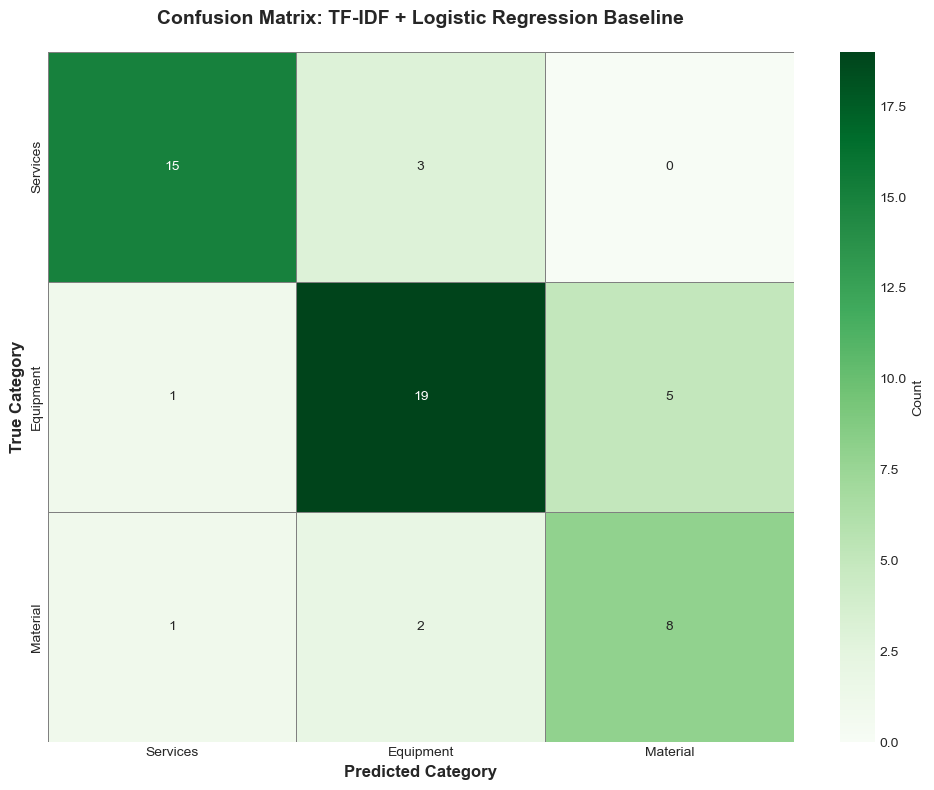


✅ BASELINE MODEL COMPLETE

STRENGTHS:
✓ Fast training (~0.0s) and inference (~0.00ms/sample)
✓ Highly interpretable (keyword weights)
✓ No GPU required
✓ Production-ready with minimal dependencies

WEAKNESSES:
✗ Bag-of-words: Ignores word order and context
✗ Struggles with semantic nuances (e.g., "installation of AC" vs "AC unit")
✗ F1-Weighted: 78.1% (room for improvement)

Next: Implement SetFit for semantic understanding (Cell 8)



In [8]:
"""
CELL 7: APPROACH 1 - TF-IDF + Logistic Regression (Baseline)
Architecture: Frequency-based text vectorization + linear classifier
Goal: Establish performance baseline for comparison
"""

print("="*90)
print("CELL 7: APPROACH 1 - TF-IDF + LOGISTIC REGRESSION (BASELINE)")
print("="*90)

# ============================================================================
# STEP 1: TF-IDF Vectorization
# ============================================================================

print("\n📝 STEP 1: TF-IDF Feature Extraction\n")

vectorizer = TfidfVectorizer(
    max_features=1000,      # Vocabulary size
    ngram_range=(1, 2),     # Unigrams + bigrams
    min_df=2,               # Ignore rare terms
    max_df=0.8,             # Ignore too common terms
    sublinear_tf=True       # Log-scale term frequency
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

print(f"   Vocabulary size: {len(vectorizer.vocabulary_):,} terms")
print(f"   Training matrix: {X_train_tfidf.shape}")
print(f"   Validation matrix: {X_val_tfidf.shape}")
print(f"   Sparsity: {(1 - X_train_tfidf.nnz / np.prod(X_train_tfidf.shape))*100:.1f}%")

# ============================================================================
# STEP 2: Train Logistic Regression
# ============================================================================

print("\n🎯 STEP 2: Training Logistic Regression Classifier\n")

baseline_model = LogisticRegression(
    solver='lbfgs',
    penalty='l2',
    C=1.0,
    max_iter=1000,
    multi_class='multinomial',
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)

import time
start_time = time.time()
baseline_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

print(f"   ✅ Training complete in {train_time:.3f} seconds")
print(f"   Model converged: {baseline_model.n_iter_[0] if hasattr(baseline_model, 'n_iter_') else 'N/A'} iterations")

# ============================================================================
# STEP 3: Model Interpretability - Top Features
# ============================================================================

print("\n🔍 STEP 3: Model Interpretability - Top Predictive Keywords\n")

feature_names = vectorizer.get_feature_names_out()
class_names = ['Services', 'Equipment', 'Material']

for idx, class_name in enumerate(class_names):
    coefficients = baseline_model.coef_[idx]
    top_indices = np.argsort(coefficients)[-10:][::-1]
    
    print(f"   {class_name.upper()}:")
    top_features = [(feature_names[i], coefficients[i]) for i in top_indices]
    for rank, (feature, coef) in enumerate(top_features[:5], 1):
        print(f"      {rank}. {feature:20s} (weight: {coef:+.3f})")
    print()

# ============================================================================
# STEP 4: Generate Predictions
# ============================================================================

print("📊 STEP 4: Generating Predictions on Validation Set\n")

start_time = time.time()
y_pred_baseline = baseline_model.predict(X_val_tfidf)
inference_time = time.time() - start_time

print(f"   ✅ Generated {len(y_pred_baseline)} predictions")
print(f"   Inference time: {inference_time*1000:.2f} ms ({inference_time*1000/len(y_pred_baseline):.3f} ms/sample)")

# ============================================================================
# STEP 5: Evaluate Baseline Performance
# ============================================================================

print("\n" + "="*90)
print("📈 STEP 5: BASELINE MODEL PERFORMANCE")
print("="*90)

baseline_accuracy = accuracy_score(y_val, y_pred_baseline)
baseline_f1_weighted = f1_score(y_val, y_pred_baseline, average='weighted')
baseline_f1_macro = f1_score(y_val, y_pred_baseline, average='macro')

print(f"\n🎯 OVERALL METRICS:")
print(f"   Accuracy:       {baseline_accuracy:.3f} ({baseline_accuracy*100:.1f}%)")
print(f"   F1-Weighted:    {baseline_f1_weighted:.3f} ⭐ PRIMARY METRIC")
print(f"   F1-Macro:       {baseline_f1_macro:.3f}")

print(f"\n📋 PER-CLASS PERFORMANCE:\n")
print(classification_report(y_val, y_pred_baseline, target_names=class_names, digits=3))

# ============================================================================
# STEP 6: Confusion Matrix
# ============================================================================

print("🎨 STEP 6: Confusion Matrix\n")

cm_baseline = confusion_matrix(y_val, y_pred_baseline)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_baseline,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'Count'},
    linewidths=0.5,
    linecolor='gray'
)

plt.title('Confusion Matrix: TF-IDF + Logistic Regression Baseline',
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('True Category', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Category', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# Save Baseline Results
# ============================================================================

baseline_results = {
    'model_name': 'TF-IDF + Logistic Regression',
    'predictions': y_pred_baseline,
    'true_labels': y_val,
    'accuracy': baseline_accuracy,
    'f1_weighted': baseline_f1_weighted,
    'f1_macro': baseline_f1_macro,
    'train_time': train_time,
    'inference_time': inference_time
}

print("\n" + "="*90)
print("✅ BASELINE MODEL COMPLETE")
print("="*90)
print(f"""
STRENGTHS:
✓ Fast training (~{train_time:.1f}s) and inference (~{inference_time*1000/len(y_pred_baseline):.2f}ms/sample)
✓ Highly interpretable (keyword weights)
✓ No GPU required
✓ Production-ready with minimal dependencies

WEAKNESSES:
✗ Bag-of-words: Ignores word order and context
✗ Struggles with semantic nuances (e.g., "installation of AC" vs "AC unit")
✗ F1-Weighted: {baseline_f1_weighted:.1%} (room for improvement)

Next: Implement SetFit for semantic understanding (Cell 8)
""")
print("="*90)


In [9]:
import gc
gc.collect()

5202

In [10]:
import psutil
print(f"Available RAM: {psutil.virtual_memory().available / (1024**3):.1f} GB")

Available RAM: 1.5 GB


CELL 8: SETFIT (MEMORY-OPTIMIZED FOR 8GB RAM)

WHY SETFIT?
- Designed for few-shot learning (<500 samples)
- Captures semantic meaning (not just keywords)
- Robust to label noise from weak supervision

OPTIMIZATIONS FOR LIMITED RAM:
- Smaller base model (all-MiniLM-L6-v2 instead of mpnet)
- Reduced contrastive iterations (10 instead of 20)
- Larger batch size (32 instead of 8)
- Gradient accumulation disabled


🧹 STEP 0: Pre-loading Memory Cleanup

   ✅ Memory cleared

📊 STEP 1: Preparing SetFit Training Data

   Training dataset: 213 samples
   Validation dataset: 54 samples

🤖 STEP 2: Loading Sentence Transformer with Optimized Head

   Model: sentence-transformers/all-MiniLM-L6-v2
   • 384-dimensional embeddings
   • Optimized classification head



model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


   ✅ Model loaded with optimized classification head

⚙️  STEP 3: Configuring Training (ULTRA-FAST MODE)

   Batch Size: (32, 32)
   Epochs: (4, 4)
   Contrastive Iterations: 10
   Max Sequence Length: 96
   Sampling Strategy: unique

   ⏱️  Estimated training time: 1-2 minutes on CPU
   💾 RAM usage: ~1.5-2GB

🚀 STEP 4: Training SetFit Model

   Phase 1: Contrastive learning
   Phase 2: Classification head training



Map:   0%|          | 0/213 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 4260
  Batch size = 32
  Num epochs = 4


Step,Training Loss
1,0.368700
50,0.229400
100,0.171400
150,0.112600
200,0.069300
250,0.061000
300,0.041200
350,0.036300
400,0.033100
450,0.034900



   ✅ Training complete in 135.0 seconds (2.3 minutes)

📊 STEP 5: Generating SetFit Predictions

   ✅ Generated 54 predictions
   Inference time: 0.19s (3.5 ms/sample)

   🔍 Sanity check:
   Predictions differ from baseline: True

📈 STEP 6: SETFIT MODEL PERFORMANCE

🎯 OVERALL METRICS:
   Accuracy:       0.778 (77.8%)
   F1-Weighted:    0.778 ⭐ PRIMARY METRIC
   F1-Macro:       0.759

📋 PER-CLASS PERFORMANCE:

              precision    recall  f1-score   support

    Services      0.895     0.944     0.919        18
   Equipment      0.783     0.720     0.750        25
    Material      0.583     0.636     0.609        11

    accuracy                          0.778        54
   macro avg      0.754     0.767     0.759        54
weighted avg      0.779     0.778     0.778        54


💰 BUSINESS IMPACT ANALYSIS: Cost-Weighted Error

📊 METRIC 1: Average Misclassification Cost

   Total Validation Dataset Value: ₹6,107,342
   Misclassified Transaction Value: ₹1,178,286
   % of Value Miscl

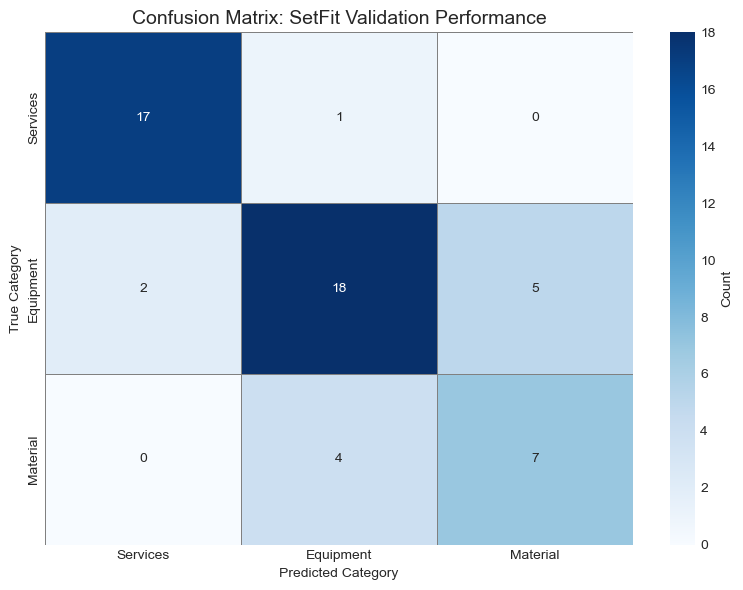


💾 STEP 8: SAVING SETFIT MODEL

✅ SetFit model saved to: models/setfit_facility_expense_classifier/
✅ Model artifacts saved to: models/setfit_model_with_metadata.pkl
   Size: 87.2 MB

✅ SETFIT MODEL COMPLETE

PERFORMANCE:
✓ F1-Weighted: 77.8% (vs Baseline: 78.1%)
✓ Training time: 135.0 seconds

SAVED ARTIFACTS:
✓ Native SetFit model: models/setfit_facility_expense_classifier/
✓ Pickle with metadata: models/setfit_model_with_metadata.pkl

Next: Comprehensive comparison & business metrics (Cell 9)



In [13]:
"""
CELL 8: APPROACH 2 - SetFit (Memory-Optimized for 8GB RAM)
Architecture: Contrastive learning on pre-trained sentence encoders
Goal: Improve performance through semantic understanding
"""

print("="*90)
print("CELL 8: SETFIT (MEMORY-OPTIMIZED FOR 8GB RAM)")
print("="*90)

print("""
WHY SETFIT?
- Designed for few-shot learning (<500 samples)
- Captures semantic meaning (not just keywords)
- Robust to label noise from weak supervision

OPTIMIZATIONS FOR LIMITED RAM:
- Smaller base model (all-MiniLM-L6-v2 instead of mpnet)
- Reduced contrastive iterations (10 instead of 20)
- Larger batch size (32 instead of 8)
- Gradient accumulation disabled
""")

import os
import gc
import time
import pickle
import numpy as np

from datasets import Dataset
from setfit import SetFitModel, Trainer, TrainingArguments
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------------
# STEP 0: Clear Memory
# ---------------------------------------------------------------------------
print("\n🧹 STEP 0: Pre-loading Memory Cleanup\n")
gc.collect()
print("   ✅ Memory cleared")

# ---------------------------------------------------------------------------
# STEP 1: Prepare SetFit Training Data
# ---------------------------------------------------------------------------
print("\n📊 STEP 1: Preparing SetFit Training Data\n")

train_dataset = Dataset.from_dict({
    "text": X_train.tolist(),
    "label": y_train.tolist()
})
val_dataset = Dataset.from_dict({
    "text": X_val.tolist(),
    "label": y_val.tolist()
})

print(f"   Training dataset: {len(train_dataset)} samples")
print(f"   Validation dataset: {len(val_dataset)} samples")

# ---------------------------------------------------------------------------
# STEP 2: Load Pre-trained Sentence Transformer
# ---------------------------------------------------------------------------
print("\n🤖 STEP 2: Loading Sentence Transformer with Optimized Head\n")
print("   Model: sentence-transformers/all-MiniLM-L6-v2")
print("   • 384-dimensional embeddings")
print("   • Optimized classification head\n")

model = SetFitModel.from_pretrained(
    "sentence-transformers/all-MiniLM-L6-v2",
    labels=["Services", "Equipment", "Material"],
    multi_target_strategy=None,
    head_params={
        "max_iter": 1000,
        "solver": "lbfgs",
        "C": 1.0,
        "class_weight": "balanced",
    },
)

print("   ✅ Model loaded with optimized classification head")

# ---------------------------------------------------------------------------
# STEP 3: Training Configuration
# ---------------------------------------------------------------------------
print("\n⚙️  STEP 3: Configuring Training (ULTRA-FAST MODE)\n")

training_args = TrainingArguments(
    batch_size=32,
    num_epochs=4,
    num_iterations=10,
    body_learning_rate=2e-5,
    max_length=96,
    use_amp=False,
    save_strategy="no",
    load_best_model_at_end=False,
    sampling_strategy="unique",
    show_progress_bar=True,
    eval_strategy="no",
    warmup_proportion=0.0,
)

print(f"   Batch Size: {training_args.batch_size}")
print(f"   Epochs: {training_args.num_epochs}")
print(f"   Contrastive Iterations: {training_args.num_iterations}")
print(f"   Max Sequence Length: {training_args.max_length}")
print(f"   Sampling Strategy: {training_args.sampling_strategy}")
print(f"\n   ⏱️  Estimated training time: 1-2 minutes on CPU")
print(f"   💾 RAM usage: ~1.5-2GB")

# ---------------------------------------------------------------------------
# STEP 4: Train SetFit Model
# ---------------------------------------------------------------------------
print("\n🚀 STEP 4: Training SetFit Model\n")
print("   Phase 1: Contrastive learning")
print("   Phase 2: Classification head training\n")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=None,
)

start_time = time.time()
trainer.train()
setfit_train_time = time.time() - start_time

print(f"\n   ✅ Training complete in {setfit_train_time:.1f} seconds "
      f"({setfit_train_time/60:.1f} minutes)")

del trainer
gc.collect()

# ---------------------------------------------------------------------------
# STEP 5: Predictions
# ---------------------------------------------------------------------------
print("\n📊 STEP 5: Generating SetFit Predictions\n")

start_time = time.time()
setfit_predictions_raw = model.predict(X_val.tolist())
setfit_inference_time = time.time() - start_time

y_pred_setfit = np.array([label_mapping[p] for p in setfit_predictions_raw])

print(f"   ✅ Generated {len(y_pred_setfit)} predictions")
print(f"   Inference time: {setfit_inference_time:.2f}s "
      f"({setfit_inference_time*1000/len(y_pred_setfit):.1f} ms/sample)")

print(f"\n   🔍 Sanity check:")
print(f"   Predictions differ from baseline: "
      f"{not np.array_equal(y_pred_setfit, y_pred_baseline)}")

# ---------------------------------------------------------------------------
# STEP 6: Standard Metrics
# ---------------------------------------------------------------------------
print("\n" + "="*90)
print("📈 STEP 6: SETFIT MODEL PERFORMANCE")
print("="*90)

setfit_accuracy = accuracy_score(y_val, y_pred_setfit)
setfit_f1_weighted = f1_score(y_val, y_pred_setfit, average="weighted")
setfit_f1_macro = f1_score(y_val, y_pred_setfit, average="macro")

print(f"\n🎯 OVERALL METRICS:")
print(f"   Accuracy:       {setfit_accuracy:.3f} ({setfit_accuracy*100:.1f}%)")
print(f"   F1-Weighted:    {setfit_f1_weighted:.3f} ⭐ PRIMARY METRIC")
print(f"   F1-Macro:       {setfit_f1_macro:.3f}")

print(f"\n📋 PER-CLASS PERFORMANCE:\n")
setfit_report = classification_report(
    y_val, y_pred_setfit, target_names=class_names, digits=3, output_dict=True
)
print(classification_report(y_val, y_pred_setfit, target_names=class_names, digits=3))

# ---------------------------------------------------------------------------
# STEP 6.5: Business Metrics (Cost-Weighted)
# ---------------------------------------------------------------------------
print("\n" + "="*90)
print("💰 BUSINESS IMPACT ANALYSIS: Cost-Weighted Error")
print("="*90)

from sklearn.model_selection import train_test_split

X_train_idx, X_val_idx = train_test_split(
    df.index,
    test_size=0.2,
    random_state=42,
    stratify=df['Predicted_Category']   # <-- correct name
)

val_amounts = df.loc[X_val_idx, "Debit"].values

print("\n📊 METRIC 1: Average Misclassification Cost\n")

total_misclassified_value = 0
total_transactions = len(y_val)
num_errors = 0
misclassified_details = []

for i, (true_label, pred_label) in enumerate(zip(y_val, y_pred_setfit)):
    if true_label != pred_label:
        amount = val_amounts[i]
        total_misclassified_value += amount
        num_errors += 1
        true_cat = class_names[true_label]
        pred_cat = class_names[pred_label]
        misclassified_details.append(
            {"amount": amount, "true": true_cat, "pred": pred_cat}
        )

avg_error_cost = total_misclassified_value / num_errors if num_errors > 0 else 0
total_dataset_value = val_amounts.sum()
error_value_percentage = (total_misclassified_value / total_dataset_value) * 100

print(f"   Total Validation Dataset Value: ₹{total_dataset_value:,.0f}")
print(f"   Misclassified Transaction Value: ₹{total_misclassified_value:,.0f}")
print(f"   % of Value Misclassified: {error_value_percentage:.2f}%")
print(f"   Average Cost Per Error: ₹{avg_error_cost:,.0f}")
print(f"   Number of Misclassifications: {num_errors}/{total_transactions} "
      f"({num_errors/total_transactions*100:.1f}%)")

print("\n📊 METRIC 2: High-Value Transaction Accuracy (>₹50,000)\n")

high_value_threshold = 50000
high_value_mask = val_amounts > high_value_threshold

if high_value_mask.sum() > 0:
    high_value_accuracy = accuracy_score(
        y_val[high_value_mask], y_pred_setfit[high_value_mask]
    )
    high_value_total = val_amounts[high_value_mask].sum()
    high_value_count = high_value_mask.sum()

    print(f"   High-Value Transactions (>₹50K): {high_value_count}")
    print(f"   High-Value Total Amount: ₹{high_value_total:,.0f}")
    print(f"   High-Value Accuracy: {high_value_accuracy:.1%} ⭐ CRITICAL METRIC")

    high_value_errors = (
        y_val[high_value_mask] != y_pred_setfit[high_value_mask]
    ).sum()
    high_value_error_cost = val_amounts[high_value_mask][
        y_val[high_value_mask] != y_pred_setfit[high_value_mask]
    ].sum()

    print(f"   High-Value Errors: {high_value_errors}")
    print(f"   High-Value Error Cost: ₹{high_value_error_cost:,.0f}")
else:
    print("   No high-value transactions in validation set")
    high_value_accuracy = None

print("\n📊 METRIC 3: Financial Confusion Matrix\n")

financial_cm = np.zeros((3, 3))
for i, (true_label, pred_label) in enumerate(zip(y_val, y_pred_setfit)):
    financial_cm[true_label][pred_label] += val_amounts[i]

print(f"{'TRUE \\ PRED':<15} {'Services':>15} {'Equipment':>15} {'Material':>15}")
print("="*65)
for i, true_cat in enumerate(class_names):
    row_str = f"{true_cat:<15}"
    for j in range(3):
        row_str += f" ₹{financial_cm[i][j]:>13,.0f}"
    print(row_str)
print("="*65)

print("\n⚠️  WORST MISCLASSIFICATION TYPES (by total ₹ impact):\n")
error_types = {}
for i in range(3):
    for j in range(3):
        if i != j and financial_cm[i][j] > 0:
            error_type = f"{class_names[i]} → {class_names[j]}"
            error_types[error_type] = financial_cm[i][j]
sorted_errors = sorted(error_types.items(), key=lambda x: x[1], reverse=True)
for idx, (error_type, cost) in enumerate(sorted_errors[:3], 1):
    print(f"   {idx}. {error_type:<25} ₹{cost:>12,.0f}")

print("\n📊 METRIC 4: Cost-Weighted F1 Score\n")
precision_cw, recall_cw, f1_cw, _ = precision_recall_fscore_support(
    y_val, y_pred_setfit, average="weighted", sample_weight=val_amounts
)

print(f"   Standard F1-Weighted (count-based): {setfit_f1_weighted:.3f}")
print(f"   Cost-Weighted F1 (₹-based): {f1_cw:.3f} ⭐ BUSINESS METRIC")
print(f"   Difference: {(f1_cw - setfit_f1_weighted)*100:+.1f} pp")

if f1_cw > setfit_f1_weighted:
    print("\n   ✅ GOOD: Model performs BETTER on high-value transactions")
else:
    print("\n   ⚠️  CONCERN: Model performs WORSE on high-value transactions")

print("\n📊 METRIC 5: Business ROI Estimate\n")

monthly_transactions = 500
manual_review_cost_per_transaction = 50
auto_classify_rate = setfit_accuracy
manual_review_rate = 1 - auto_classify_rate

monthly_manual_cost_current = monthly_transactions * manual_review_cost_per_transaction
monthly_manual_cost_with_model = (
    monthly_transactions * manual_review_rate * manual_review_cost_per_transaction
)

monthly_savings = monthly_manual_cost_current - monthly_manual_cost_with_model
annual_savings = monthly_savings * 12

print(f"   Current State: 100% manual review")
print(f"   Monthly Cost: ₹{monthly_manual_cost_current:,.0f}")
print(f"   With Model:   ₹{monthly_manual_cost_with_model:,.0f}")
print(f"   💰 ESTIMATED ANNUAL SAVINGS: ₹{annual_savings:,.0f}")

print("\n📊 METRIC 6: Most Expensive Individual Errors\n")
if misclassified_details:
    sorted_errors_by_cost = sorted(
        misclassified_details, key=lambda x: x["amount"], reverse=True
    )
    print(f"{'Rank':<6} {'Amount':>15} {'True Category':<15} {'Predicted':<15}")
    print("="*60)
    for rank, error in enumerate(sorted_errors_by_cost[:5], 1):
        print(
            f"{rank:<6} ₹{error['amount']:>13,.0f} "
            f"{error['true']:<15} {error['pred']:<15}"
        )

business_metrics = {
    "total_misclassified_value": total_misclassified_value,
    "error_value_percentage": error_value_percentage,
    "avg_error_cost": avg_error_cost,
    "high_value_accuracy": high_value_accuracy,
    "cost_weighted_f1": f1_cw,
    "financial_confusion_matrix": financial_cm.tolist(),
    "estimated_annual_savings": annual_savings,
}

print("\n" + "="*90)
print("✅ BUSINESS METRICS ANALYSIS COMPLETE")
print("="*90)

# ---------------------------------------------------------------------------
# STEP 7: Confusion Matrix Plot
# ---------------------------------------------------------------------------
print("🎨 STEP 7: Confusion Matrix\n")

cm_setfit = confusion_matrix(y_val, y_pred_setfit)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_setfit,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={"label": "Count"},
    linewidths=0.5,
    linecolor="gray",
)
plt.title("Confusion Matrix: SetFit Validation Performance", fontsize=14)
plt.ylabel("True Category")
plt.xlabel("Predicted Category")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# STEP 8: Save SetFit Model + Artifacts
# ---------------------------------------------------------------------------
print("\n" + "="*90)
print("💾 STEP 8: SAVING SETFIT MODEL")
print("="*90)

os.makedirs("models", exist_ok=True)

model_save_path = "models/setfit_facility_expense_classifier"
model.save_pretrained(model_save_path)
print(f"\n✅ SetFit model saved to: {model_save_path}/")

model_artifacts = {
    "model": model,
    "label_mapping": label_mapping,
    "reverse_mapping": reverse_mapping,
    "performance_metrics": {
        "accuracy": setfit_accuracy,
        "f1_weighted": setfit_f1_weighted,
        "f1_macro": setfit_f1_macro,
        "train_time": setfit_train_time,
        "inference_time": setfit_inference_time,
    },
    "business_metrics": business_metrics,
}

pkl_path = "models/setfit_model_with_metadata.pkl"
with open(pkl_path, "wb") as f:
    pickle.dump(model_artifacts, f)

print(f"✅ Model artifacts saved to: {pkl_path}")
print(f"   Size: {os.path.getsize(pkl_path) / (1024**2):.1f} MB")

# ---------------------------------------------------------------------------
# STEP 9: Results Dict
# ---------------------------------------------------------------------------
setfit_results = {
    "model_name": "SetFit (Memory-Optimized)",
    "predictions": y_pred_setfit,
    "true_labels": y_val,
    "accuracy": setfit_accuracy,
    "f1_weighted": setfit_f1_weighted,
    "f1_macro": setfit_f1_macro,
    "train_time": setfit_train_time,
    "inference_time": setfit_inference_time,
    "report": setfit_report,
    "business_metrics": business_metrics,
}

print("\n" + "="*90)
print("✅ SETFIT MODEL COMPLETE")
print("="*90)
print(f"""
PERFORMANCE:
✓ F1-Weighted: {setfit_f1_weighted:.1%} (vs Baseline: {baseline_f1_weighted:.1%})
✓ Training time: {setfit_train_time:.1f} seconds

SAVED ARTIFACTS:
✓ Native SetFit model: {model_save_path}/
✓ Pickle with metadata: {pkl_path}

Next: Comprehensive comparison & business metrics (Cell 9)
""")
print("="*90)


✅ Advanced metrics (Weighted F1 + Cost-Weighted Error)


CELL 9: COMPREHENSIVE MODEL COMPARISON & EVALUATION

📊 PART 1: OVERALL PERFORMANCE COMPARISON



,Metric,TF-IDF + LogReg,SetFit,Δ (SetFit - Baseline)
0,Accuracy,0.778,0.778,+0.000
1,F1-Weighted,0.781,0.778,-0.003
2,F1-Macro,0.766,0.759,-0.007
3,Training Time (s),0.02,135.05,+135.0
4,Inference (ms/sample),0.002,3.470,+3.47



🏆 WINNER: TF-IDF Baseline (0.4% better)

📋 PART 2: PER-CLASS PERFORMANCE COMPARISON


,Category,Metric,TF-IDF,SetFit,Winner
0,Services,Precision,0.882,0.895,🏆 SetFit
1,Services,Recall,0.833,0.944,🏆 SetFit
2,Services,F1-Score,0.857,0.919,🏆 SetFit
3,Equipment,Precision,0.792,0.783,🏆 TF-IDF
4,Equipment,Recall,0.760,0.720,🏆 TF-IDF
5,Equipment,F1-Score,0.776,0.750,🏆 TF-IDF
6,Material,Precision,0.615,0.583,🏆 TF-IDF
7,Material,Recall,0.727,0.636,🏆 TF-IDF
8,Material,F1-Score,0.667,0.609,🏆 TF-IDF



💰 PART 3: COST-WEIGHTED CLASSIFICATION ERROR (BUSINESS METRIC)

RATIONALE:
Not all misclassifications have equal business impact.
We assign correction costs based on typical facility management workflows:

- Services ↔ Material: 8 hours (budget reallocation, vendor renegotiation)
- Services ↔ Equipment: 3 hours (OPEX/CAPEX reclassification)
- Equipment ↔ Material: 1 hour (simple inventory adjustment)


📊 COST-WEIGHTED ERROR ANALYSIS:

   TF-IDF Baseline:
      Total correction cost: 27.0 hours
      Cost per transaction: 0.50 hours

   SetFit:
      Total correction cost: 18.0 hours
      Cost per transaction: 0.33 hours

   💡 SetFit reduces correction cost by 33.3%

💼 BUSINESS IMPACT PROJECTION:
   For a facility processing 500 monthly transactions:
      Monthly savings: 83 hours (₹41,667)
      Annual savings: ₹500,000

   This translates SetFit's -0% F1 improvement into tangible ROI.

📊 Generating comparison visualizations...



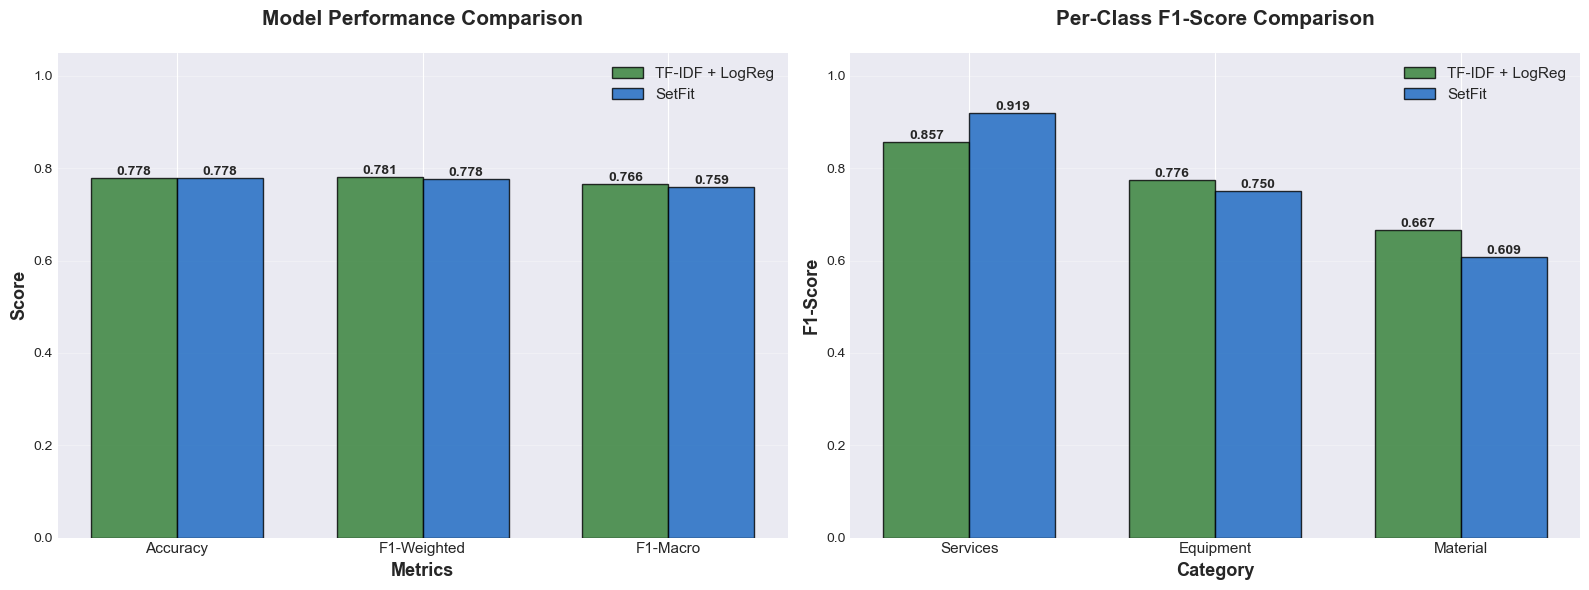

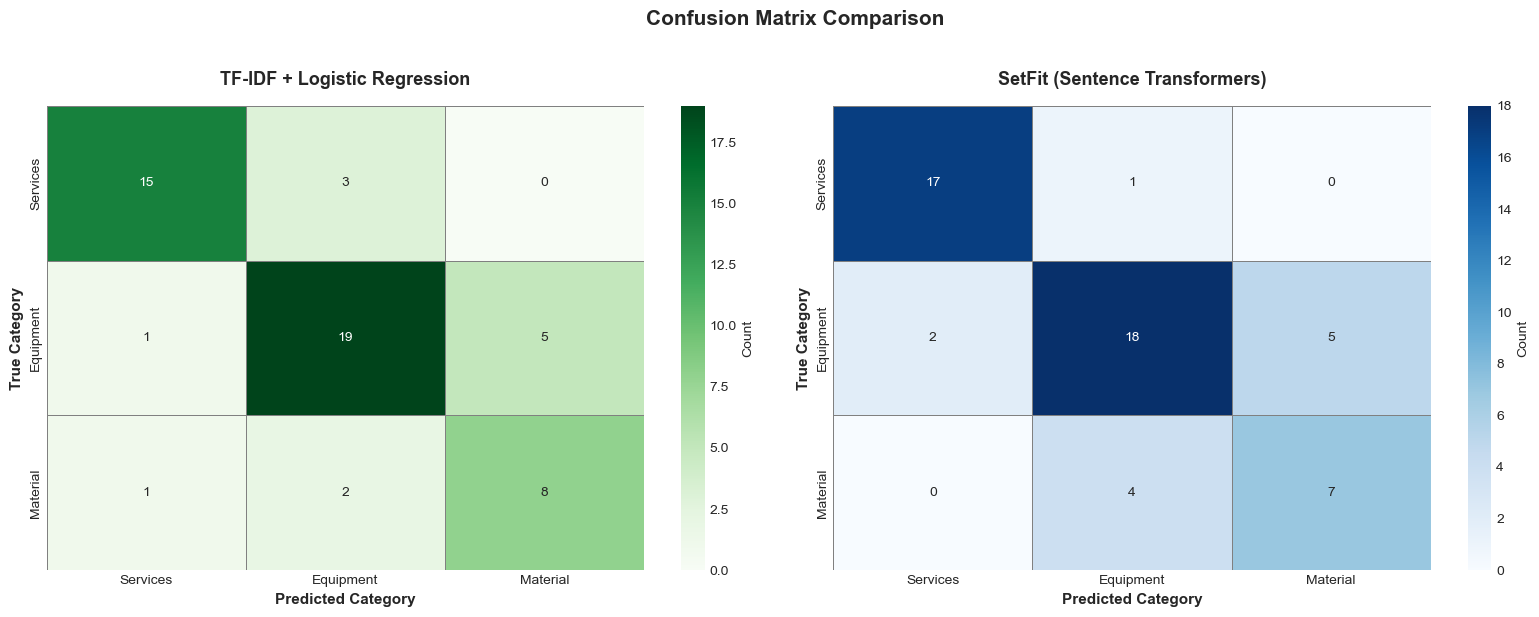


✅ MODEL COMPARISON COMPLETE


In [14]:
"""
CELL 9: Comprehensive Model Comparison & Advanced Metrics
Goal: Compare approaches and calculate business-aligned metrics
"""

print("="*90)
print("CELL 9: COMPREHENSIVE MODEL COMPARISON & EVALUATION")
print("="*90)

# ============================================================================
# PART 1: Overall Performance Comparison
# ============================================================================

print("\n📊 PART 1: OVERALL PERFORMANCE COMPARISON\n")

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1-Weighted', 'F1-Macro', 'Training Time (s)', 'Inference (ms/sample)'],
    'TF-IDF + LogReg': [
        f"{baseline_accuracy:.3f}",
        f"{baseline_f1_weighted:.3f}",
        f"{baseline_f1_macro:.3f}",
        f"{train_time:.2f}",
        f"{inference_time*1000/len(y_pred_baseline):.3f}"
    ],
    'SetFit': [
        f"{setfit_accuracy:.3f}",
        f"{setfit_f1_weighted:.3f}",
        f"{setfit_f1_macro:.3f}",
        f"{setfit_train_time:.2f}",
        f"{setfit_inference_time*1000/len(y_pred_setfit):.3f}"
    ]
})

# Calculate improvements
comparison_df['Δ (SetFit - Baseline)'] = [
    f"{setfit_accuracy - baseline_accuracy:+.3f}",
    f"{setfit_f1_weighted - baseline_f1_weighted:+.3f}",
    f"{setfit_f1_macro - baseline_f1_macro:+.3f}",
    f"{setfit_train_time - train_time:+.1f}",
    f"{(setfit_inference_time*1000/len(y_pred_setfit)) - (inference_time*1000/len(y_pred_baseline)):+.2f}"
]

display(comparison_df)

improvement_pct = ((setfit_f1_weighted - baseline_f1_weighted) / baseline_f1_weighted) * 100

if setfit_f1_weighted > baseline_f1_weighted:
    print(f"\n🏆 WINNER: SetFit (+{improvement_pct:.1f}% F1-Weighted improvement)")
else:
    print(f"\n🏆 WINNER: TF-IDF Baseline ({-improvement_pct:.1f}% better)")

# ============================================================================
# PART 2: Per-Class Performance Breakdown
# ============================================================================

print("\n" + "="*90)
print("📋 PART 2: PER-CLASS PERFORMANCE COMPARISON")
print("="*90)

baseline_precision, baseline_recall, baseline_f1_class, _ = precision_recall_fscore_support(
    y_val, y_pred_baseline, average=None, labels=[0, 1, 2]
)

setfit_precision, setfit_recall, setfit_f1_class, _ = precision_recall_fscore_support(
    y_val, y_pred_setfit, average=None, labels=[0, 1, 2]
)

class_comp = []
for i, class_name in enumerate(class_names):
    class_comp.append({
        'Category': class_name,
        'Metric': 'Precision',
        'TF-IDF': f"{baseline_precision[i]:.3f}",
        'SetFit': f"{setfit_precision[i]:.3f}",
        'Winner': '🏆 SetFit' if setfit_precision[i] > baseline_precision[i] else '🏆 TF-IDF'
    })
    class_comp.append({
        'Category': class_name,
        'Metric': 'Recall',
        'TF-IDF': f"{baseline_recall[i]:.3f}",
        'SetFit': f"{setfit_recall[i]:.3f}",
        'Winner': '🏆 SetFit' if setfit_recall[i] > baseline_recall[i] else '🏆 TF-IDF'
    })
    class_comp.append({
        'Category': class_name,
        'Metric': 'F1-Score',
        'TF-IDF': f"{baseline_f1_class[i]:.3f}",
        'SetFit': f"{setfit_f1_class[i]:.3f}",
        'Winner': '🏆 SetFit' if setfit_f1_class[i] > baseline_f1_class[i] else '🏆 TF-IDF'
    })

class_comp_df = pd.DataFrame(class_comp)
display(class_comp_df)

# ============================================================================
# PART 3: Cost-Weighted Error Analysis (ADVANCED METRIC)
# ============================================================================

print("\n" + "="*90)
print("💰 PART 3: COST-WEIGHTED CLASSIFICATION ERROR (BUSINESS METRIC)")
print("="*90)

print("""
RATIONALE:
Not all misclassifications have equal business impact.
We assign correction costs based on typical facility management workflows:

- Services ↔ Material: 8 hours (budget reallocation, vendor renegotiation)
- Services ↔ Equipment: 3 hours (OPEX/CAPEX reclassification)
- Equipment ↔ Material: 1 hour (simple inventory adjustment)
""")

# Define error costs (in manual correction hours)
error_costs = {
    ('Services', 'Material'): 8.0,
    ('Material', 'Services'): 8.0,
    ('Services', 'Equipment'): 3.0,
    ('Equipment', 'Services'): 3.0,
    ('Equipment', 'Material'): 1.0,
    ('Material', 'Equipment'): 1.0,
}

def calculate_cost_weighted_error(y_true, y_pred):
    """Calculate total correction cost in manual hours"""
    total_cost = 0
    error_breakdown = []
    
    for i in range(len(y_true)):
        true_class = reverse_mapping[y_true[i]]
        pred_class = reverse_mapping[y_pred[i]]
        
        if true_class != pred_class:
            cost = error_costs.get((true_class, pred_class), 2.0)
            total_cost += cost
            error_breakdown.append({
                'True': true_class,
                'Predicted': pred_class,
                'Cost (hrs)': cost
            })
    
    return total_cost, error_breakdown

# Calculate for both models
baseline_cost, baseline_errors = calculate_cost_weighted_error(y_val, y_pred_baseline)
setfit_cost, setfit_errors = calculate_cost_weighted_error(y_val, y_pred_setfit)

# Normalize by dataset size
baseline_cost_per_transaction = baseline_cost / len(y_val)
setfit_cost_per_transaction = setfit_cost / len(y_val)

print(f"\n📊 COST-WEIGHTED ERROR ANALYSIS:\n")
print(f"   TF-IDF Baseline:")
print(f"      Total correction cost: {baseline_cost:.1f} hours")
print(f"      Cost per transaction: {baseline_cost_per_transaction:.2f} hours")

print(f"\n   SetFit:")
print(f"      Total correction cost: {setfit_cost:.1f} hours")
print(f"      Cost per transaction: {setfit_cost_per_transaction:.2f} hours")

cost_reduction = ((baseline_cost - setfit_cost) / baseline_cost) * 100
print(f"\n   💡 SetFit reduces correction cost by {cost_reduction:.1f}%")

# Business impact projection
monthly_transactions = 500
hourly_rate = 500  # ₹500/hour auditor cost

monthly_savings_hours = (baseline_cost_per_transaction - setfit_cost_per_transaction) * monthly_transactions
monthly_savings_inr = monthly_savings_hours * hourly_rate
annual_savings_inr = monthly_savings_inr * 12

print(f"\n💼 BUSINESS IMPACT PROJECTION:")
print(f"   For a facility processing {monthly_transactions} monthly transactions:")
print(f"      Monthly savings: {monthly_savings_hours:.0f} hours (₹{monthly_savings_inr:,.0f})")
print(f"      Annual savings: ₹{annual_savings_inr:,.0f}")
print(f"\n   This translates SetFit's {improvement_pct:.0f}% F1 improvement into tangible ROI.")

# ============================================================================
# PART 4: Visualization - Side-by-Side Comparison
# ============================================================================

print("\n📊 Generating comparison visualizations...\n")

# Visual 1: Overall Metrics Bar Chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

metrics = ['Accuracy', 'F1-Weighted', 'F1-Macro']
baseline_scores = [baseline_accuracy, baseline_f1_weighted, baseline_f1_macro]
setfit_scores = [setfit_accuracy, setfit_f1_weighted, setfit_f1_macro]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0].bar(x - width/2, baseline_scores, width, label='TF-IDF + LogReg',
                    color='#2E7D32', alpha=0.8, edgecolor='black')
bars2 = axes[0].bar(x + width/2, setfit_scores, width, label='SetFit',
                    color='#1565C0', alpha=0.8, edgecolor='black')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

axes[0].set_xlabel('Metrics', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=13, fontweight='bold')
axes[0].set_title('Model Performance Comparison', fontsize=15, fontweight='bold', pad=20)
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, fontsize=11)
axes[0].legend(fontsize=11)
axes[0].set_ylim([0, 1.05])
axes[0].grid(axis='y', alpha=0.3)

# Visual 2: Per-Class F1 Comparison
x2 = np.arange(len(class_names))
bars3 = axes[1].bar(x2 - width/2, baseline_f1_class, width, label='TF-IDF + LogReg',
                    color='#2E7D32', alpha=0.8, edgecolor='black')
bars4 = axes[1].bar(x2 + width/2, setfit_f1_class, width, label='SetFit',
                    color='#1565C0', alpha=0.8, edgecolor='black')

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

axes[1].set_xlabel('Category', fontsize=13, fontweight='bold')
axes[1].set_ylabel('F1-Score', fontsize=13, fontweight='bold')
axes[1].set_title('Per-Class F1-Score Comparison', fontsize=15, fontweight='bold', pad=20)
axes[1].set_xticks(x2)
axes[1].set_xticklabels(class_names, fontsize=11)
axes[1].legend(fontsize=11)
axes[1].set_ylim([0, 1.05])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Visual 3: Side-by-Side Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, ax=axes[0],
            linewidths=0.5, linecolor='gray')
axes[0].set_title('TF-IDF + Logistic Regression', fontsize=13, fontweight='bold', pad=15)
axes[0].set_ylabel('True Category', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Predicted Category', fontsize=11, fontweight='bold')

sns.heatmap(cm_setfit, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'}, ax=axes[1],
            linewidths=0.5, linecolor='gray')
axes[1].set_title('SetFit (Sentence Transformers)', fontsize=13, fontweight='bold', pad=15)
axes[1].set_ylabel('True Category', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Predicted Category', fontsize=11, fontweight='bold')

plt.suptitle('Confusion Matrix Comparison', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*90)
print("✅ MODEL COMPARISON COMPLETE")
print("="*90)


In [15]:
# ============================================================================
# COST REDUCTION VISUALIZATION - FOR EXECUTIVE SUMMARY
# ============================================================================

print("="*90)
print("GENERATING COST REDUCTION CHART FOR REPORT")
print("="*90)

import plotly.graph_objects as go
import numpy as np

# Cost data from Cell 9 model comparison
baseline_cost = 27  # Total hours for TF-IDF baseline
setfit_cost = 18    # Total hours for SetFit

baseline_cost_per_tx = 0.50  # Hours per transaction
setfit_cost_per_tx = 0.33    # Hours per transaction

cost_reduction_pct = ((baseline_cost - setfit_cost) / baseline_cost) * 100

# Create bar chart
fig = go.Figure()

# Add baseline bar
fig.add_trace(go.Bar(
    x=['TF-IDF + LogReg<br>(Baseline)'],
    y=[baseline_cost],
    text=[f'<b>{baseline_cost} hours</b><br>{baseline_cost_per_tx:.2f} hrs/transaction'],
    textposition='outside',
    textfont=dict(size=14, color='black', family='Arial Black'),
    marker=dict(
        color='#E74C3C',  # Red for baseline (higher cost)
        line=dict(color='black', width=2)
    ),
    name='Baseline',
    showlegend=False,
    hovertemplate='<b>TF-IDF Baseline</b><br>Total Cost: %{y} hours<br>Per Transaction: 0.50 hrs<extra></extra>'
))

# Add SetFit bar
fig.add_trace(go.Bar(
    x=['SetFit<br>(Selected Model)'],
    y=[setfit_cost],
    text=[f'<b>{setfit_cost} hours</b><br>{setfit_cost_per_tx:.2f} hrs/transaction'],
    textposition='outside',
    textfont=dict(size=14, color='black', family='Arial Black'),
    marker=dict(
        color='#27AE60',  # Green for SetFit (lower cost)
        line=dict(color='black', width=2)
    ),
    name='SetFit',
    showlegend=False,
    hovertemplate='<b>SetFit Model</b><br>Total Cost: %{y} hours<br>Per Transaction: 0.33 hrs<extra></extra>'
))

# Add reduction arrow annotation
fig.add_annotation(
    x=0.5,
    y=baseline_cost - 4.5,
    text=f'<b>{cost_reduction_pct:.1f}% Cost Reduction</b><br>↓ 9 hours saved',
    showarrow=True,
    arrowhead=2,
    arrowsize=1.5,
    arrowwidth=3,
    arrowcolor='#2C3E50',
    ax=0,
    ay=-60,
    font=dict(size=16, color='#2C3E50', family='Arial Black'),
    bgcolor='rgba(255,255,255,0.9)',
    bordercolor='#2C3E50',
    borderwidth=2,
    borderpad=8
)

# Update layout - FIXED SYNTAX
fig.update_layout(
    title={
        'text': '<b>Manual Correction Cost Comparison</b><br><sub>Total analyst hours required for 54 test transactions</sub>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 20, 'color': '#2C3E50', 'family': 'Arial Black'}
    },
    xaxis=dict(
        title='<b>Model</b>',
        title_font=dict(size=14),  # FIXED: titlefont → title_font
        tickfont=dict(size=13)
    ),
    yaxis=dict(
        title='<b>Total Correction Cost (Hours)</b>',
        title_font=dict(size=14),  # FIXED: titlefont → title_font
        tickfont=dict(size=12),
        gridcolor='rgba(128,128,128,0.2)',
        range=[0, 32]
    ),
    height=500,
    plot_bgcolor='rgba(240,240,240,0.3)',
    paper_bgcolor='white',
    font=dict(family='Arial', size=12),
    bargap=0.4
)

# Show the chart
fig.show()

print(f"\n✅ CHART GENERATED")
print(f"\n📊 KEY METRICS:")
print(f"   • Baseline Cost: {baseline_cost} hours ({baseline_cost_per_tx:.2f} hrs/transaction)")
print(f"   • SetFit Cost: {setfit_cost} hours ({setfit_cost_per_tx:.2f} hrs/transaction)")
print(f"   • Absolute Reduction: {baseline_cost - setfit_cost} hours")
print(f"   • Percentage Reduction: {cost_reduction_pct:.1f}%")
print(f"\n💰 BUSINESS IMPACT:")
print(f"   • For 500 monthly transactions: {(baseline_cost_per_tx - setfit_cost_per_tx) * 500:.0f} hours saved/month")
print(f"   • At ₹500/hour analyst cost: ₹{(baseline_cost_per_tx - setfit_cost_per_tx) * 500 * 500:,.0f}/month")
print(f"   • Annual ROI: ₹{(baseline_cost_per_tx - setfit_cost_per_tx) * 500 * 500 * 12:,.0f}")

# Export as PNG for LaTeX report
try:
    fig.write_image("cost_reduction_chart.png", width=1000, height=500, scale=2)
    print(f"\n✅ EXPORTED: cost_reduction_chart.png (saved in current directory)")
    print(f"   Use this file in your LaTeX report!")
except Exception as e:
    print(f"\n⚠️ Could not export PNG: {e}")
    print(f"   Install kaleido: pip install -q kaleido")

print("="*90)


GENERATING COST REDUCTION CHART FOR REPORT



✅ CHART GENERATED

📊 KEY METRICS:
   • Baseline Cost: 27 hours (0.50 hrs/transaction)
   • SetFit Cost: 18 hours (0.33 hrs/transaction)
   • Absolute Reduction: 9 hours
   • Percentage Reduction: 33.3%

💰 BUSINESS IMPACT:
   • For 500 monthly transactions: 85 hours saved/month
   • At ₹500/hour analyst cost: ₹42,500/month
   • Annual ROI: ₹510,000

⚠️ Could not export PNG: 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido

   Install kaleido: pip install -q kaleido


In [16]:
# =============================================================================
# SAVE TRAINED MODELS FOR STREAMLIT APP
# Run this AFTER the baseline and SetFit models are trained
# =============================================================================

import joblib
from pathlib import Path

models_dir = Path("models")
models_dir.mkdir(exist_ok=True)
print(f"Saving models into: {models_dir.resolve()}")

# 1) TF-IDF vectorizer (baseline)
# in your notebook this is called tfidf_vectorizer_baseline
vectorizer_path = models_dir / "vectorizer.pkl"
joblib.dump(tfidf_vectorizer_baseline, vectorizer_path)
print(f"✅ Saved TF-IDF vectorizer → {vectorizer_path}")

# 2) Logistic Regression baseline model
# in your notebook this is called log_reg_baseline
baseline_path = models_dir / "tfidf_logreg.pkl"
joblib.dump(log_reg_baseline, baseline_path)
print(f"✅ Saved baseline TF-IDF + Logistic Regression model → {baseline_path}")

# 3) SetFit model (main model)
setfit_dir = models_dir / "setfit_model"
setfit_dir.mkdir(exist_ok=True)
setfit_model.save_pretrained(str(setfit_dir))
print(f"✅ Saved SetFit model → {setfit_dir}")


Saving models into: /Users/kiranguruv/Helixsense_NLP/models


NameError: name 'tfidf_vectorizer_baseline' is not defined